In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import xgboost as xgb
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
import torch.optim as to

# Load the Dataset Check Label Class Ratio

In [8]:

# Load the dataset
file_path = 'framingham.csv'
data = pd.read_csv(file_path)
# Retrieve Labels classes (0,1)
total_rows = len(data)
hypCount= (data['prevalentHyp']==1).sum()
chdCount= (data['TenYearCHD']==1).sum()
hypZeroCount = total_rows - hypCount
chdZeroCount = total_rows - chdCount

# Print the ratio of zeroes to ones for 'prevalentHyp'
print(f"PrevalentHyp - Zeroes to Ones Ratio: {round(hypZeroCount/total_rows,2)}:{round(hypCount/total_rows,2)}")

# Print the ratio of zeroes to ones for 'TenYearCHD'
print(f"TenYearCHD - Zeroes to Ones Ratio: {round(chdZeroCount/total_rows,2)}:{round(chdCount/total_rows,2)}")


print("Dataset Feature List: "+ str(data.drop(columns=['prevalentHyp', 'TenYearCHD']).columns.tolist() ) )

PrevalentHyp - Zeroes to Ones Ratio: 0.69:0.31
TenYearCHD - Zeroes to Ones Ratio: 0.85:0.15
Dataset Feature List: ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']


# Note how unbalanced the distribution is for these labels in the Framingham Dataset

In [9]:
# Features With Good Correlation
features = ['male', 'age', 'education', 'currentSmoker', 'cigsPerDay', 'BPMeds', 'prevalentStroke', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
data_c = data.copy()

# Permutate Null values with median values
for feature in features:
    if data_c[feature].isnull().sum() > 0:
        data_c[feature] = data_c[feature].fillna(data_c[feature].median())

# Remove outlier values within range [Q1 - 3* IQR : Q1 + 3* IQR]
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound) & (df[column] != 0)]

outlier_feat = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI']

for col in outlier_feat:
    data_c = remove_outliers(data_c, col)

print(data_c)



      male  age  education  currentSmoker  cigsPerDay  BPMeds  \
0        1   39        4.0              0         0.0     0.0   
1        0   46        2.0              0         0.0     0.0   
2        1   48        1.0              1        20.0     0.0   
3        0   61        3.0              1        30.0     0.0   
4        0   46        3.0              1        23.0     0.0   
...    ...  ...        ...            ...         ...     ...   
4235     0   48        2.0              1        20.0     0.0   
4236     0   44        1.0              1        15.0     0.0   
4237     0   52        2.0              0         0.0     0.0   
4238     1   40        3.0              0         0.0     0.0   
4239     0   39        3.0              1        30.0     0.0   

      prevalentStroke  prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  \
0                   0             0         0    195.0  106.0   70.0  26.97   
1                   0             0         0    250.0  121.0

# Analyze Feature Distribution to Infer Potential Useful Features for Hypertension and Coronary Heart Disease

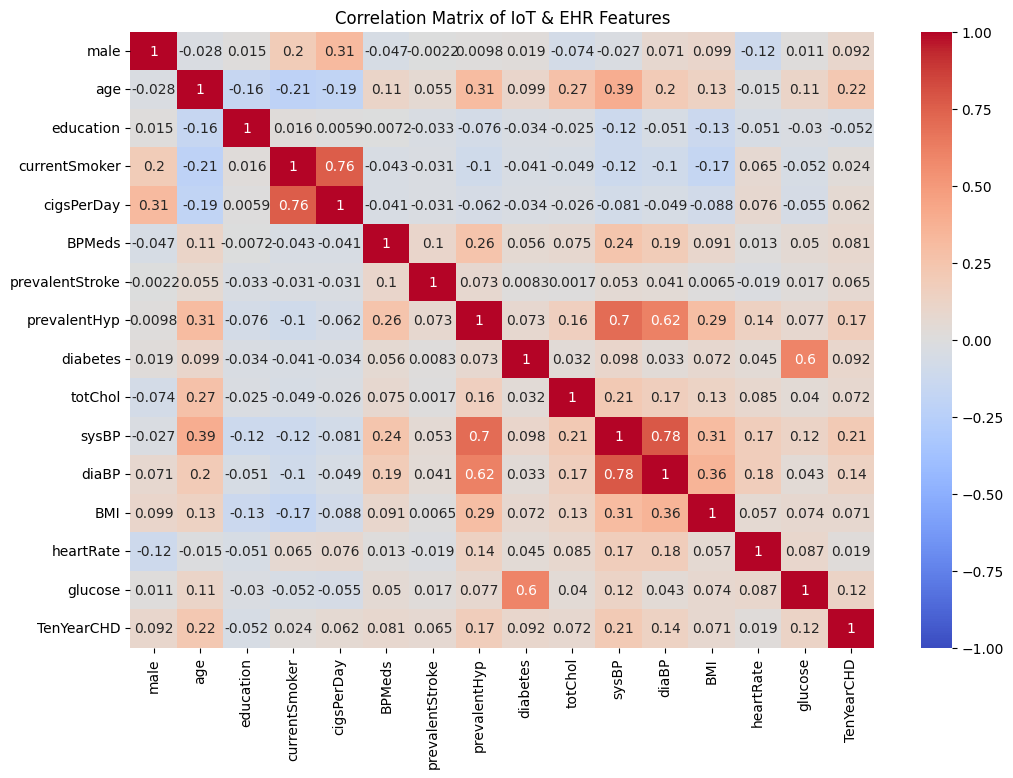

In [10]:
# Dataframe Correlation Matrix to select features correlating well with PrevalentHyp, CHD
plt.figure(figsize=(12, 8))
sns.heatmap(data_c.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of IoT & EHR Features')
plt.show()


# Test Model Accuracy of Individual Tasks Separately using XGBoost

In [12]:

# Prepare the dataset for modeling
select_features = ['age', 'totChol', 'BPMeds', 'sysBP', 'diaBP', 'BMI', 'cigsPerDay']

X = data_c[select_features]
y_hypertension = data_c['prevalentHyp']
y_chd = data_c['TenYearCHD']

# Splitting the data for training and testing
X_train, X_test, y_chd_train, y_chd_test = train_test_split(X, y_chd, test_size=0.2, random_state=42)
_, _, y_hypertension_train, y_hypertension_test = train_test_split(X, y_hypertension, test_size=0.2, random_state=42)

# Train XGBoost model for Hypertension
xgb_hypertension = xgb.XGBClassifier()
xgb_hypertension.fit(X_train, y_hypertension_train)
y_hypertension_pred = xgb_hypertension.predict(X_test)
hypertension_accuracy = accuracy_score(y_hypertension_test, y_hypertension_pred)
print(f'Hypertension Model Accuracy: {hypertension_accuracy:.4f}')

# Train XGBoost model for CHD
xgb_chd = xgb.XGBClassifier()
xgb_chd.fit(X_train, y_chd_train)
y_chd_pred = xgb_chd.predict(X_test)
chd_accuracy = accuracy_score(y_chd_test, y_chd_pred)
print(f'CHD Model Accuracy: {chd_accuracy:.4f}')

Hypertension Model Accuracy: 0.8766
CHD Model Accuracy: 0.8280


In [38]:
# Prepare and split the dataset for modeling
X = data_c[select_features]
y_hypertension = data_c['prevalentHyp']
y_chd = data_c['TenYearCHD']

X_train, X_test, y_chd_train, y_chd_test = train_test_split(X, y_chd, test_size=0.2, random_state=42)
_, _, y_hypertension_train, y_hypertension_test = train_test_split(X, y_hypertension, test_size=0.2, random_state=42)

# Train XGBoost model for both conditions
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_chd_train)
y_chd_pred = xgb_model.predict(X_test)

xgb_model.fit(X_train, y_hypertension_train)
y_hypertension_pred = xgb_model.predict(X_test)

# Calculate metrics
chd_accuracy = accuracy_score(y_chd_test, y_chd_pred)
chd_precision = precision_score(y_chd_test, y_chd_pred)
chd_recall = recall_score(y_chd_test, y_chd_pred)
chd_f1 = f1_score(y_chd_test, y_chd_pred)

hypertension_accuracy = accuracy_score(y_hypertension_test, y_hypertension_pred)
hypertension_precision = precision_score(y_hypertension_test, y_hypertension_pred)
hypertension_recall = recall_score(y_hypertension_test, y_hypertension_pred)
hypertension_f1 = f1_score(y_hypertension_test, y_hypertension_pred)

# Average metrics
average_accuracy = (chd_accuracy + hypertension_accuracy) / 2
average_precision = (chd_precision + hypertension_precision) / 2
average_recall = (chd_recall + hypertension_recall) / 2
average_f1 = (chd_f1 + hypertension_f1) / 2

# results
metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'CHD': [chd_accuracy, chd_precision, chd_recall, chd_f1],
    'Hypertension': [hypertension_accuracy, hypertension_precision, hypertension_recall, hypertension_f1],
    'Average': [average_accuracy, average_precision, average_recall, average_f1]
}
metrics_df = pd.DataFrame(metrics_data)
print(metrics_df.to_string(index=False))

   Metric      CHD  Hypertension  Average
 Accuracy 0.827995      0.876631 0.852313
Precision 0.282609      0.803279 0.542944
   Recall 0.104000      0.777778 0.440889
 F1 Score 0.152047      0.790323 0.471185


# Test Dataset on a Pre-built Multi-Task Classifier (TabNet Variant)

In [31]:
#Shuffle Data
datac_shuff = data_c.sample(frac=1, random_state=42).reset_index(drop=True)

# Features based on Correlation with Labels
X =datac_shuff[select_features]

# Two different labels for multi-task classification
y1 = datac_shuff['prevalentHyp']
y2 = datac_shuff['TenYearCHD']
# Combine labels
y = np.vstack((y1, y2)).T

# # Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# print(X_valid)

scaler = StandardScaler()
X_train[outlier_feat] = scaler.fit_transform(X_train[outlier_feat])
X_valid[outlier_feat]= scaler.transform(X_valid[outlier_feat])

X_train=X_train.values
X_valid = X_valid.values


# # Initialize the TabNetMultiTaskClassifier
clf = TabNetMultiTaskClassifier(
    cat_idxs=[2], 
    cat_dims=[2],  
    cat_emb_dim=1,  
    optimizer_fn=to.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={"step_size": 50, "gamma": 0.9},
    scheduler_fn=to.lr_scheduler.StepLR,
    mask_type='entmax'
)

# Fit the model
clf.fit(
    X_train=X_train,
    y_train=y_train,
    eval_set=[(X_valid, y_valid)],  
    eval_name=['valid'],
    eval_metric=['accuracy', 'auc', 'balanced_accuracy'], 
    max_epochs=50,  # Total Epochs
    patience=10,  # ٍStop After 10 Unimprovments
    batch_size=128,
    virtual_batch_size=32,
    num_workers=1,
    drop_last=False
)

# Make predictions
preds = clf.predict(X_valid)



C:\Users\saria\anaconda3\envs\fedenv\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.43722 | valid_accuracy: 0.86358 | valid_auc: 0.76433 | valid_balanced_accuracy: 0.67177 |  0:00:09s
epoch 1  | loss: 0.35226 | valid_accuracy: 0.87426 | valid_auc: 0.80867 | valid_balanced_accuracy: 0.69501 |  0:00:19s
epoch 2  | loss: 0.34391 | valid_accuracy: 0.87485 | valid_auc: 0.7971  | valid_balanced_accuracy: 0.69098 |  0:00:28s
epoch 3  | loss: 0.34141 | valid_accuracy: 0.87011 | valid_auc: 0.81331 | valid_balanced_accuracy: 0.68195 |  0:00:38s
epoch 4  | loss: 0.33479 | valid_accuracy: 0.86714 | valid_auc: 0.8201  | valid_balanced_accuracy: 0.69573 |  0:00:47s
epoch 5  | loss: 0.3406  | valid_accuracy: 0.87544 | valid_auc: 0.81468 | valid_balanced_accuracy: 0.69518 |  0:00:57s
epoch 6  | loss: 0.34312 | valid_accuracy: 0.87307 | valid_auc: 0.84649 | valid_balanced_accuracy: 0.70777 |  0:01:06s
epoch 7  | loss: 0.34199 | valid_accuracy: 0.86714 | valid_auc: 0.84806 | valid_balanced_accuracy: 0.68692 |  0:01:16s
epoch 8  | loss: 0.33694 | valid_accuracy: 0.869

C:\Users\saria\anaconda3\envs\fedenv\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Divide Dataset into Multiple CSV Files for Federated Learning Training and Evaluation/Testing

In [14]:
#Split and save CSVs as client1 (Hypertension), client1 (CHD), Test Dataset
dataset=data_c[ select_features + ['prevalentHyp','TenYearCHD'] ]
client1=dataset.iloc[:1800].drop(columns=['TenYearCHD'])
client2=dataset.iloc[1800:3600].drop(columns=['prevalentHyp'])
test =  dataset.iloc[3600:]
client1.to_csv('fl/client1.csv')
client2.to_csv('fl/client2.csv')
test.to_csv('fl/test.csv')

print('Done')


Done
